## CS224 - Winter 2024
## HW 3: Dog Denoiser

Submit **PDF** of completed IPython notebook on **Canvas**

**Due**: March 12, 2024 @ 11:59pm PDT

**Maximum points**: 15 (each HW is %15 of total grade)

# Overview
In this assignment, we will make a linear and nonlinear dog denoiser (inspired by the need to restore a damaged image of Sir Fluffles III to its former glory as discussed in class).
Complete all the code marked `TODO`.

### Import libraries, data, viz data
This section can remain unchanged.

Using device: cuda
Example images of CIFAR-10 dogs


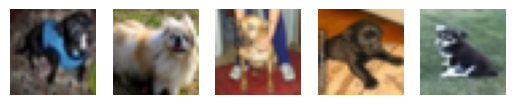

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import SGD  # Our chosen optimizer
from torch.utils.data import DataLoader, TensorDataset
from nets import UNet

# from google.colab import drive
# drive.mount('/content/drive')

# X, y = torch.load('/content/drive/MyDrive/CS224-FunadamentalsOfMachineLearning/HW2-DeepFakeCatDetector/hw2_data.pt')

def show_image(xs):
    """Display a list of CIFAR-10 images in a table.
    Images may be flattened or unflattened.
    Assumes floats in range [0,1] representing colors"""
    xs = xs.cpu()
    n = len(xs)
    fig, axs = plt.subplots(1, n)
    for i, ax in enumerate(axs):
        x = xs[i].reshape(3, 32, 32).moveaxis(0, -1)
        x = torch.clamp(x, 0., 1.)
        ax.imshow(x)
        ax.axis('off')
    return fig

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# datasets are small enough to be loaded on GPU
# usually we leave on CPU and only put the training batch on GPU
dogs_train, dogs_val = torch.load('hw3_data.pt', map_location=device)
val_loader = DataLoader(TensorDataset(dogs_val), batch_size=50, drop_last=True)

def test_model(model, val_loader=val_loader):
    """Code to test MSE on validation data."""
    criterion = nn.MSELoss()
    model.eval()
    mse = 0.
    with torch.no_grad():
        for x, in val_loader:
            x_noise = x + 0.1 * torch.randn_like(x)
            x_hat = model(x_noise).view(x.shape)
            mse += criterion(x, x_hat) / len(val_loader)
    return mse

print("Example images of CIFAR-10 dogs")
fig = show_image(dogs_train[:5])

### Linear denoiser (6 points)

We will use PCA to define a linear denoiser.
First, we encode the data into a latent factor using the top 500 principal components, then we decode to recover a (denoised) version of the image that lies on the linear subspace spanned by the first 500 components.
I found it convenient to put a "flatten" operation inside fit and forward, so I could just input the images directly with the same shape as for the UNet.

In [ ]:
class LinearDenoiser(nn.Module):
    """Denoise by projecting onto linear subspace spanned by
    top principal components."""
    def __init__(self, d=500):
        super(LinearDenoiser, self).__init__()
        self.d = d  # Number of principal components to use
        # We won't use backprop on this model,
        # so you can initialize/store parameters however you like
        self.topk_eigenvectors_from_pca = 0
        self.mean_of_data = 0

    def forward(self, x):
        # print("Shape of x before flatten ", x.shape)
        x = x.flatten(start_dim=1)  # Flatten images to vectors
        # print("Shape of x after flatten ", x.shape)
        z = self.encode(x)
        # print("Shape of z before calling decode ", z.shape)
        x_hat = self.decode(z)
        return x_hat

    def encode(self, x):
        # TODO [1 points]: encode x into low-d latent space
        # Get encoding matrix
        encoding_matrix = self.topk_eigenvectors_from_pca
        z = torch.mm(x - self.mean_of_data, encoding_matrix)
        return z

    def decode(self, z):
        # TODO [1 points]: linearly decode back to x-space
        # Get decoding matrix
        decoding_matrix = self.topk_eigenvectors_from_pca.t()
        # print("Shape of z in decode ", z.shape)
        # print("Shape of decoding_matrix ", decoding_matrix.shape)
        # print("Shape of mean ", self.mean_of_data.shape)
        x_hat = torch.mm(z, decoding_matrix) + self.mean_of_data
        return x_hat

    def fit(self, x):
        # TODO [4 points]: Use PCA to get the parameters
        # Don't forget to center the data and store mean
        # for reconstruction.
        # Use SVD to get eigenvectors of covariance,
        # like I did in class

        # We need to flatten the tensor x which will be 4d for CIFAR10 to 2-d
        x = x.flatten(start_dim = 1)

        # Center the data
        mean = x.mean(dim=0)
        n = len(x)  # number of images
        x = (x - mean)

        # Use SVD to get eigenvectors of covariance matrix
        # But first get the covariance matrix using matrix multiplication of xT and x and divide by n
        covar_matrix = torch.mm(x.t(), x) / n

        # Use SVD (Single Value Decomposition)
        # U_copy is identical to U as Covariance Matrix is symmetric
        U, S, U_copy = torch.svd(covar_matrix)

        # return top d eigenvectors, which are the basis along which there is max. variance
        # Can return only top k eigenvectors from U as U_copy is same as U
        self.topk_eigenvectors_from_pca = U[:, :self.d]
        self.mean_of_data = mean

linear_model = LinearDenoiser()
linear_model.fit(dogs_train)

### Train U-Net [5 points]
Use the included U-Net, and train it to denoise images
by minimizing the Mean Square Error loss (nn.MSELoss) between images and reconstructions from a noisy version of the image.
Use a noise standard deviation of 0.1.
Train with SGD.

In [ ]:
# TODO [5 points]
# Train the UNet.
# This one is a little slow to train.
# I got reasonable results in 20 epochs on my laptop, in about 30 mins
# However, you might want to learn how to use cuda() on colab
# to dramatically speed this up.

# Referenced my own code from HW2-DeepFakeCatDetector for a train function
# And modified it to fit this task
def train(model, train_loader, n_epochs, optimizer, criterion):
    """Train model using data from train_loader over n_epochs,
    using a Pytorch "optimizer" object (SGD in this case)
    and "criterion" as the loss function (MSELoss in this case).
    """

    for epoch in range(n_epochs):
        # TODO: Train loop
        print ("This is epoch - ", epoch + 1)
        # Train mode
        model.train()

        # Set the current loss and validation loss value to zero
        currentLoss = 0

        #Iterate over training data
        for x, in train_loader:
            # x = x.flatten(start_dim = 1)  # Flatten X from [batch_size, 3, 32, 32] to [batch_size, 3072]
            x_noise = x + 0.1 * torch.randn_like(x)

            # Zero the gradients from the last loss.backward() to start anew for each batch
            optimizer.zero_grad()

            # Get predictions for inputs
            reconstructed_x = model(x_noise)

            # Calculate the loss using the criterion
            loss = criterion(reconstructed_x, x)

            # Use backpropogation to find the gradients
            loss.backward()

            optimizer.step()

            print("Batch Training Loss = ",loss.item())

# Initialize important stuff
learning_rate = 0.05
n_epochs = 100
batch_size = 50

model = UNet().to(device)
criterion = nn.MSELoss()
optimizer = SGD(model.parameters(), lr = learning_rate)

# Create training and validation loaders
# drop_last = true --> parameter ignores the last batch (when the number of examples in your dataset is not divisible by your batch_size)
# while drop_last=False will make the last batch smaller than your batch_size
train_loader = DataLoader(TensorDataset(dogs_train.to(device)), batch_size=50, drop_last=True)
val_loader = DataLoader(TensorDataset(dogs_val.to(device)), batch_size=50, drop_last=True)

In [ ]:
# Call the train function
train(model, train_loader, n_epochs, optimizer, criterion)

Streaming output truncated to the last 5000 lines.
Batch Training Loss =  0.003502381034195423
Batch Training Loss =  0.002930995309725404
Batch Training Loss =  0.003098332555964589
Batch Training Loss =  0.0029791153501719236
Batch Training Loss =  0.0031129992567002773
Batch Training Loss =  0.0038405233062803745
Batch Training Loss =  0.0029591890051960945
Batch Training Loss =  0.003098340006545186
Batch Training Loss =  0.006541120354086161
Batch Training Loss =  0.0031310697086155415
Batch Training Loss =  0.003115047700703144
Batch Training Loss =  0.004437048453837633
Batch Training Loss =  0.0029143185820430517
Batch Training Loss =  0.0029244350735098124
Batch Training Loss =  0.003476275596767664
Batch Training Loss =  0.0030001963023096323
Batch Training Loss =  0.003029044484719634
Batch Training Loss =  0.003227377776056528
Batch Training Loss =  0.0032805975060909986
Batch Training Loss =  0.0032802296336740255
Batch Training Loss =  0.0030274109449237585
Batch Training

###  Results [4 points]

You shouldn't need to change the code below. It just prints out denoised images and validation loss using your trained UNet and fitted Linear model.

4 points for getting correct looking results. It should be possible to get MSE below 0.01 (value for no denoising at all), and the denoised images should be noticeably better, for linear and nonlinear denoisers

Original images


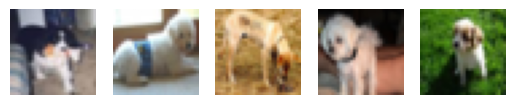

Noisy images


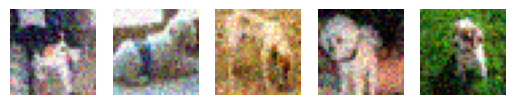

Linear denoising


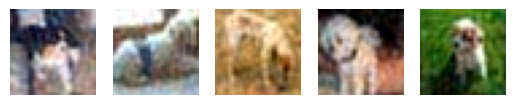

UNet denoising


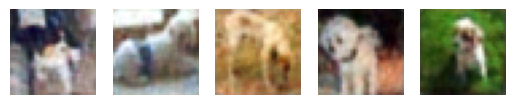

Linear model Val MSE: 0.0026
UNet Val MSE: 0.0024


In [ ]:
dogs = dogs_val[:5].cpu()
noisy_dogs = dogs + 0.1 * torch.randn_like(dogs)  # Done on CPU to avoid MPS bug!
# print(noisy_dogs.shape)
with torch.no_grad():
    linear_denoise = linear_model.forward(noisy_dogs.to(device)).cpu()
    unet_denoise = model(noisy_dogs.to(device)).cpu()

# print("Original images")
# display(show_image(dogs))
# print("Noisy images")
# display(show_image(noisy_dogs))
# print("Linear denoising")
# display(show_image(linear_denoise))
# print("UNet denoising")
# display(show_image(unet_denoise))

print("Original images")
show_image(dogs)
plt.show()
print("Noisy images")
show_image(noisy_dogs)
plt.show()
print("Linear denoising")
show_image(linear_denoise)
plt.show()
print("UNet denoising")
show_image(unet_denoise)
plt.show()

linear_mse = test_model(linear_model)
unet_mse = test_model(model)
print(f"Linear model Val MSE: {linear_mse:.4f}")
print(f"UNet Val MSE: {unet_mse:.4f}")